In [ ]:
# to resume in a separate notebook the work with ~ 2000 genes that we have found to be liver-specific
# the analysis below is carried with ClusterProfiler

In [3]:
suppressMessages({

library(data.table, quietly = TRUE)
library(plyr, quietly = TRUE)
library(doParallel,quietly = TRUE)
library(tidyverse, quietly = TRUE)
library("stringr", quietly = TRUE)
library("reactome.db")
library("AnnotationHub")
library("org.Hs.eg.db")
library("AnnotationDbi")
library("ReactomePA")
library("EnsDb.Hsapiens.v86")
library("clusterProfiler")
library("DOSE")
library(msigdbr)
})

cores <- detectCores()
cores
registerDoParallel(cores=cores)
options(future.globals.maxSize = Inf)

[1] 10

In [4]:
a = read.table("df4.pc.samples.of.interest.txt.liver.specific.genes.txt", header=T, sep="\t", stringsAsFactors=F)
head(a,2)
name = basename("df4.pc.samples.of.interest.txt.liver.specific.genes.txt")
GENES = a$gene
length(GENES)

median_tpm_Liver median_tpm_Other LO       gene  
1 28.935           20.460           1.414223 ISG15 
2  5.877            4.422           1.329037 SCNN1D

[1] 1938

In [5]:
# To have the Entrez ID for these liver-specific genes

length(GENES)
GENES_id = bitr(GENES, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
GENES_entrez_id = GENES_id$ENTREZID
length(GENES_entrez_id)

[1] 1938

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(GENES, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
"0.62% of input gene IDs are fail to map..."


[1] 1928

In [ ]:
# To have a data frame that contains Entrez ID, Ensembl ID, and Gene Symbol

In [6]:
gene.df <- bitr(GENES_entrez_id, fromType = "ENTREZID",
       toType = c("ENSEMBL", "SYMBOL"),
       OrgDb = org.Hs.eg.db)
head(gene.df,1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(GENES_entrez_id, fromType = "ENTREZID", toType = c("ENSEMBL", :
"0.1% of input gene IDs are fail to map..."


ENTREZID ENSEMBL         SYMBOL
1 9636     ENSG00000187608 ISG15

In [7]:
# In this section, we use the functions from ClusterProfiler to compute the pathway enrichment.
# As a reference, we start with GO enrichment analysis.

The results are consistent with liver biology

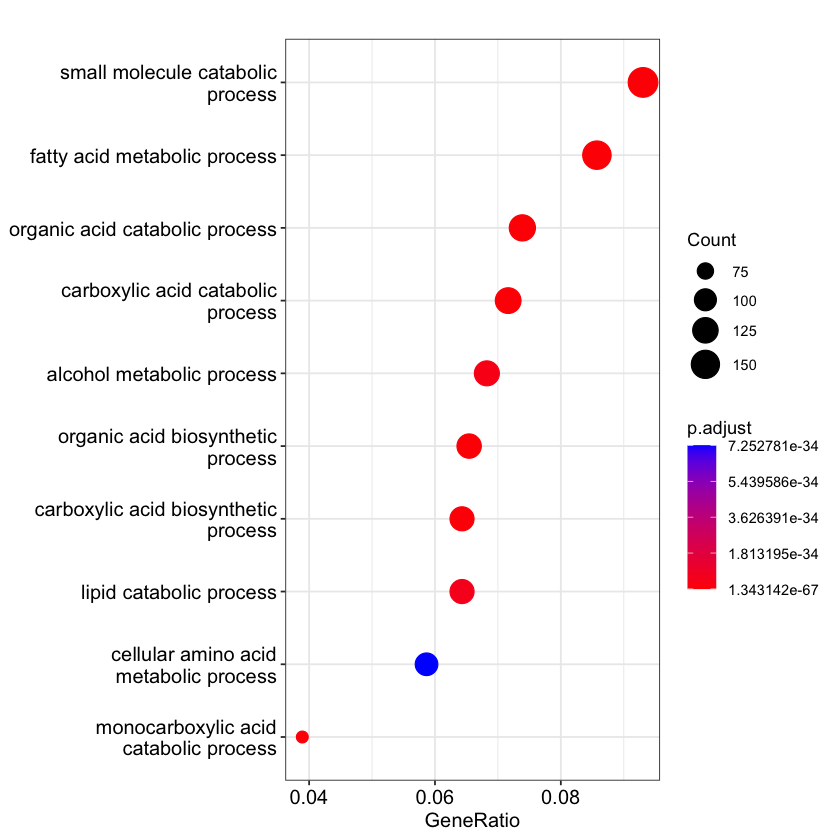

In [8]:
ego = enrichGO(gene = GENES_entrez_id,
                OrgDb        = org.Hs.eg.db,
                ont          = "BP",
                minGSSize    = 100,
                maxGSSize    = 500,
                pvalueCutoff = 0.01)
dotplot(ego)

cat(paste0('The results are consistent with liver biology'))

In [ ]:
# Enrichment in KEGG pathways

ID     Description                                                  
M00101 M00101 Cholesterol biosynthesis, squalene 2,3-epoxide => cholesterol
M00087 M00087 beta-Oxidation                                               
M00095 M00095 C5 isoprenoid biosynthesis, mevalonate pathway               
       GeneRatio BgRatio pvalue       p.adjust    qvalue     
M00101 9/230     11/852  0.0002178055 0.009147831 0.008253682
M00087 9/230     12/852  0.0006665491 0.009540072 0.008607583
M00095 8/230     10/852  0.0006814337 0.009540072 0.008607583
       geneID                                          Count
M00101 1718/51478/6307/7108/1717/6309/4047/10682/50814 9    
M00087 34/33/30/1962/3033/1892/37/51/10449             9    
M00095 3158/10654/3157/3156/39/3422/38/4598            8

The results confirm liver functions in fatty acid metabolism and cholesterol biosynthesis

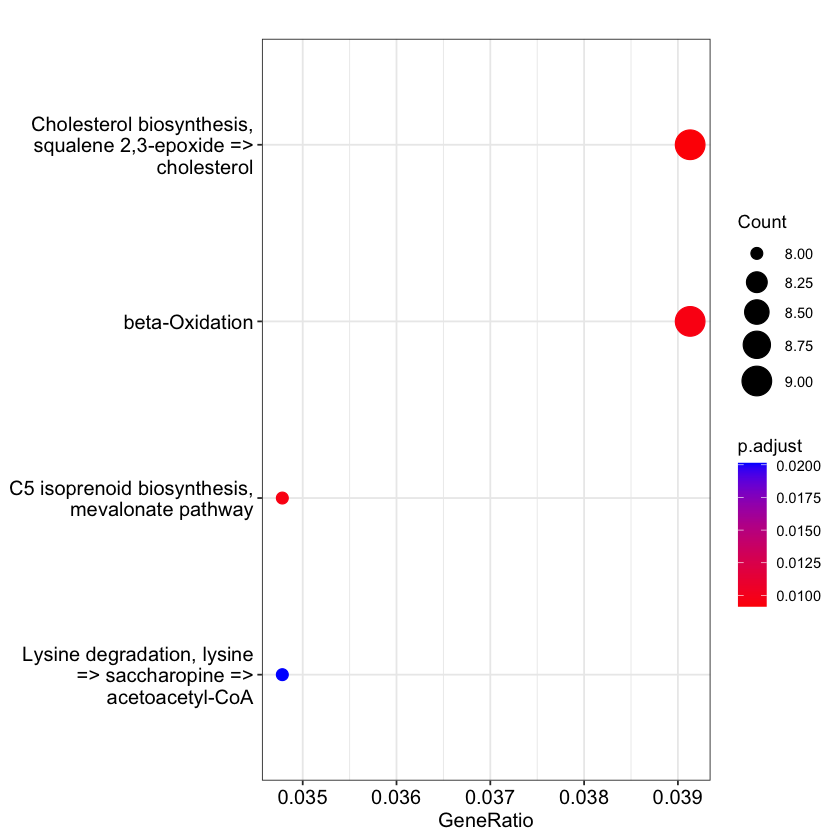

In [12]:
hsa <- search_kegg_organism('Homo sapiens', by='scientific_name')

mkk <- enrichMKEGG(gene = GENES_entrez_id,
                   organism = 'hsa',
                   pvalueCutoff = 0.1,
                   qvalueCutoff = 0.05)
head(mkk,3)

dotplot(mkk)

cat(paste0('The results confirm liver functions in fatty acid metabolism and cholesterol biosynthesis'))


In [ ]:
# Enrichment in Reactome Pathways

I could make the same comments when performing Reactome pathway analysis

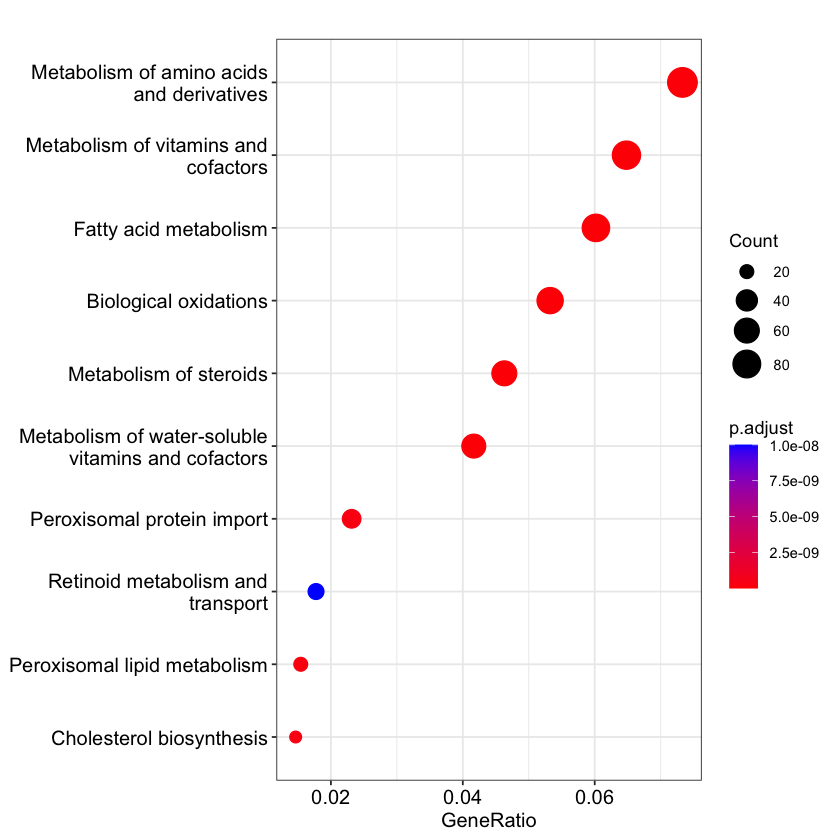

In [13]:
library("ReactomePA")

reactome_enrich <- enrichPathway(gene=GENES_entrez_id, pvalueCutoff = 1, readable=TRUE)
dotplot(reactome_enrich)

cat(paste0('I could make the same comments when performing Reactome pathway analysis'))

In [14]:
# Enrichment in Disease Ontology

Given the fact that liver is a major organ that regulates body metabolism, 
its disfunction translates into a large variety of metabolic disorders 

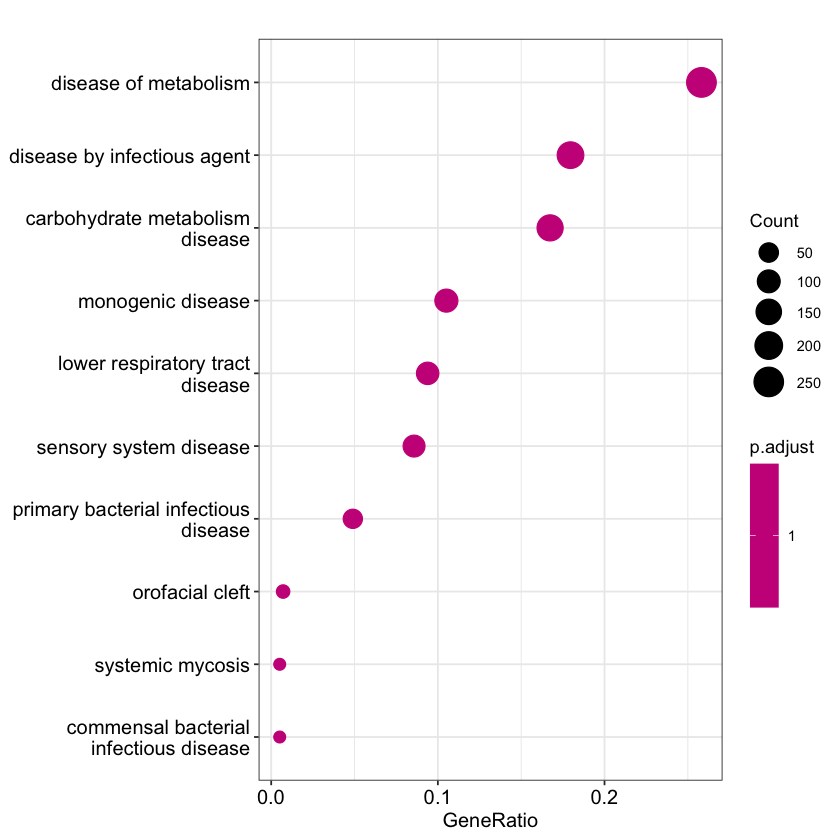

In [19]:
disease <- enrichDO(gene          = GENES_entrez_id,
              ont           = "DO",
              pvalueCutoff  = 1,
              pAdjustMethod = "BH",
              universe      = GENES_entrez_id,
              minGSSize     = 5,
              maxGSSize     = 500,
              qvalueCutoff  = 1,
              readable      = FALSE)

dotplot(disease)

cat(paste0('Given the fact that liver is a major organ that regulates body metabolism, 
its disfunction translates into a large variety of metabolic disorders '))

In [ ]:
# Enrichment in pathways reported in MSigdbr

Not surprinsingly, the top hit is MTOR. Since its discovery, mTOR has been recognized 
as the central node of a network that controls cell growth and development and regulates 
liver lipid metabolism through various mechanisms 

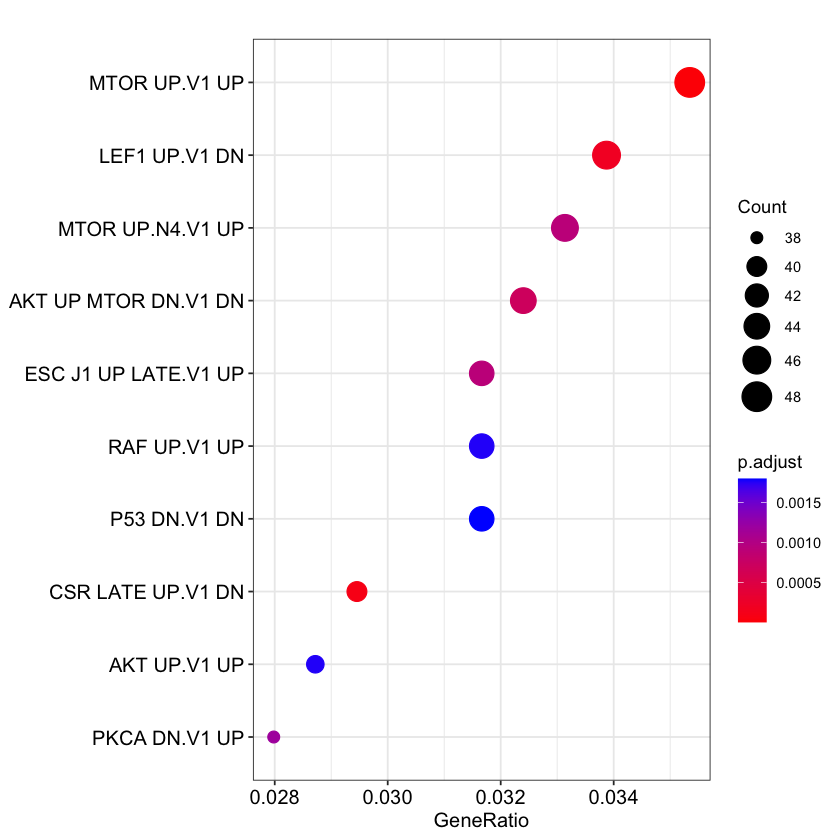

In [20]:
m_df <- msigdbr(species = "Homo sapiens")
m_t2g <- msigdbr(species = "Homo sapiens", category = "C6") %>% dplyr::select(gs_name, entrez_gene)
em <- enricher(GENES_entrez_id, TERM2GENE=m_t2g)
dotplot(em)

cat(paste0('Not surprinsingly, the top hit is MTOR. Since its discovery, mTOR has been recognized 
as the central node of a network that controls cell growth and development and regulates 
liver lipid metabolism through various mechanisms '))

In [ ]:
# Over-representation in Disease Network

ID       Description    GeneRatio BgRatio   pvalue       p.adjust    
C0242339 C0242339 Dyslipidemias  122/1821  471/21671 2.140540e-30 1.745825e-26
C0020473 C0020473 Hyperlipidemia 120/1821  472/21671 4.208027e-29 1.716034e-25
         qvalue      
C0242339 1.211546e-26
C0020473 1.190872e-25
         geneID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
C0242339 2166/6342/1376/1573/3953/8991/3570/1401/336/2328/10216/2494/1116/3290/2590/183/3398/6382/2646/51141/1803/3667/51540/4615/22937/2876/55349/28999/11343/185/4311/213/3576/27163/345275/6696/6307/5562/3156/2745/55856/55937/8645/5167/8876/2099/6648/196/51085/3082/5243/5054/4189/373156/5919/4482/1666/4982/10221/2875/123/375704/19/3934/6256/6387/8879/5950/6319/10062/3992/9415/4041/1374/84649/345/335/4055/8435/51561/4598/217/949/540/5104/3990/597/8800/290/3418/3483/368/6296/1071/2806/3931/3240/5336/6462/6720/2688/2194/9388/55620/718/51129/100125288/3949/55908/53345/602/348/344/10998/9935/6590/6647/2678/7494/3162/5465/367
C0020473 5320/84879/1376/3953/1401/336/2214/2215/2153/462/3075/3898/1999/3290/3664/2590/183/3398/6382/64838/30061/2335/1593/3667/55349/1356/590/213/5473/5562/3156/3077/55937/4907/2099/6648/39/56975/196/1956/51085/5243/5054/10135/4189/5919/1668/1666/6383/4982/2875/364/19/3934/10999/2219/57412/51703/36/196743/1571/5140/6288/847/10062/4041/1374/84649/38/4837/345/335/2542/22914/4040/8435/4035/3479/5836/3990/597/11057/290/3483/1066/1071/3931/3240/5345/6720/26073/6352/2688/2081/2194/56005/8740/718/51129/4542/100125288/3949/55908/1050/57817/348/341/344/7052/6590/6647/875/10587/3053/2678/3162/1565/5465/9104/367                  
         Count
C0242339 122  
C0020473 120

Liver regulatory role of the lipid metabolism is confirm by the enrichment analysis of 
Disease Network Genes

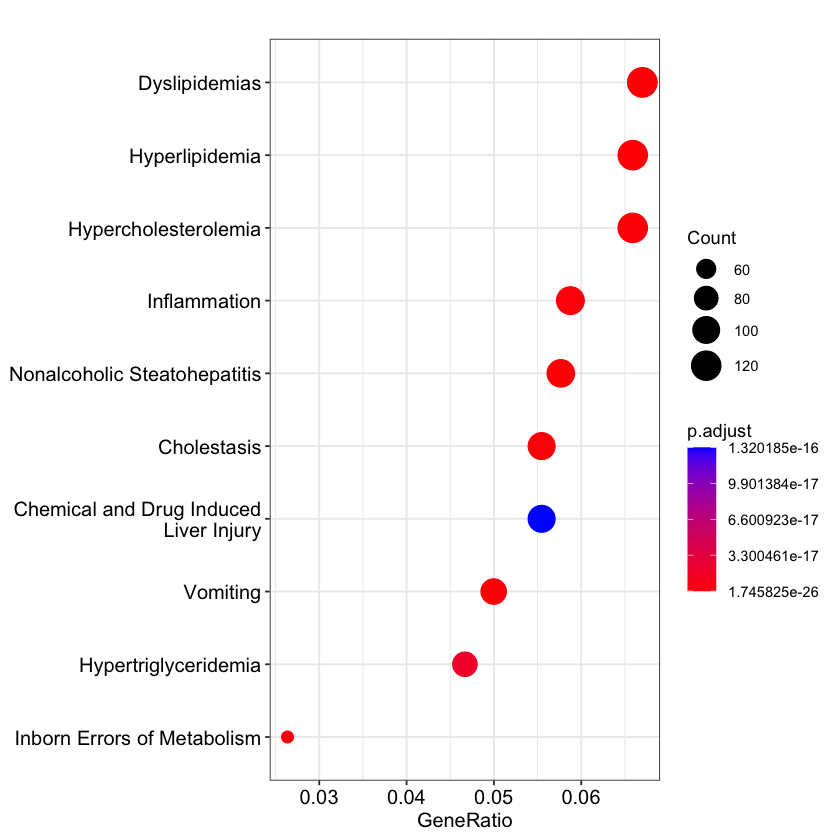

In [22]:
dgn <- enrichDGN(GENES_entrez_id) 
head(dgn,2)
dotplot(dgn)

cat(paste0('Liver regulatory role of the lipid metabolism is confirm by the enrichment analysis of 
Disease Network Genes'))